# Conditional Generative Adversarial Networks

To understand intution behind this model follow this blog:

1. [Conditional Generative Adversarial Networks (CGAN): Introduction and Implementation](https://theailearner.com/2019/09/27/conditional-generative-adversarial-networks-cgan-introduction-and-implementation/)

## Introduction

Generative adversarial networks (GANs) are trained to generate new images that look similar to original images. Let say we have trained a GAN network on MNIST digit dataset that consists of 0-9 handwritten digits. Now if we generate images from this trained GAN network, it will randomly generate images which can be any digit between 0 to 9. But if we want to generate images only for a particular digit, it will be difficult. One way is to find a mapping between random noise given as input to generator and images generated by the network. But with the variations in random input noise, it is really difficult to find the mapping. Here comes the conditional GANs.

A GAN network will be a conditional GAN if we train both the discriminator and generator conditioned on some sort of auxiliary information. This information can be class labels, black&white images, and other modalities. In this blog, we will learn how to generate images from a conditional GANs (cGAN) conditioned on the class label.\

### Imports and Initialize Parameters

In [12]:
from keras.layers import Input, Dense, Reshape, BatchNormalization, LeakyReLU, Conv2DTranspose, Conv2D, AveragePooling2D, Flatten, Embedding, Concatenate
from keras.models import Model
from keras.optimizers import Adam
from keras.datasets import mnist
import numpy as np

In [13]:
import tensorflow as tf

#ignore warnings in the output
tf.logging.set_verbosity(tf.logging.ERROR)

In [14]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
batch_size = 16
half_batch_size = 8
latent_dim = 100
iterations = 50000
optimizer = Adam(0.0002, 0.5)

### Generator in Conditional GAN

In generator we are taking two inputs, one is random noise of shape (100,) and another is class label of shape (1,) which will be an integer between 0-9. This extra input taken as class label will be our condition to GAN. During test time we will use this class label as a condition to generate images for that specific class only.

Here we have also added Embedding layer to this conditional input which consists of weights and will be trained during the generator training. This embedding layer converts positive integers to a dense vector of fixed size. Here we have taken embedding of size 50. After this embedding layer we have added a dense layer and then reshaped it to make compatible during concatenation with random noise.

In [26]:
def generator():

    input_gen = Input(shape = (1, ))
    embed_gen = Embedding(10, 50)(input_gen)
    dense_layer_gen = Dense(7*7)(embed_gen)
    reshaped_dense_gen = Reshape((7, 7, 1))(dense_layer_gen)

    input_gen_2 = Input(shape = (latent_dim,))
    dense1 = Reshape((7,7,16))(Dense(7*7*16)(input_gen_2))

    concat_layer_gen = Concatenate()([reshaped_dense_gen, dense1])
    batch_norm_1 = BatchNormalization()(concat_layer_gen)
    trans_1 = Conv2DTranspose(128, 3, padding='same', activation=LeakyReLU(alpha=0.2), strides=(2, 2))(batch_norm_1)
    batch_norm_2 = BatchNormalization()(trans_1)
    trans_2 = Conv2DTranspose(128, 3, padding='same', activation=LeakyReLU(alpha=0.2), strides=(2, 2))(batch_norm_2)
    output = Conv2D(1, (28,28), activation='tanh', padding='same')(trans_2)
    gen_model = Model([input_gen, input_gen_2], output)
    gen_model.compile(loss='binary_crossentropy', optimizer=optimizer)
    print(gen_model.summary())

    return gen_model

In [27]:
generator_model = generator() 

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 1, 50)        500         input_15[0][0]                   
__________________________________________________________________________________________________
input_16 (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 1, 49)        2499        embedding_6[0][0]                
__________________________________________________________________________________________________
dense_12 (

### Discriminator in Conditional GAN

In discriminator also we are taking two inputs one is image of shape (28, 28, 1) and another is class label of shape (1,) which will be an integer between 0-9. Discriminator is consists of convolution, batch norm and pooling layer. Output from discriminator will discriminate beteen real (images from training data) and fake images (images generated by generator network). Also embedding layer is used to achieve similar purpose as it was used in generator network.

In [28]:
def discriminator():

    input_class = Input(shape = (1, ))
    embed = Embedding(10, 50)(input_class)
    dense_layer = Dense(28*28)(embed)
    reshaped_dense = Reshape((28,28,1))(dense_layer)

    input_disc = Input(shape = (28, 28, 1))

    concat_layer = Concatenate()([input_disc, reshaped_dense])
    conv_1 = Conv2D(16, 3, padding = 'same', activation = LeakyReLU(alpha=0.2))(concat_layer)
    batch_norm1 = BatchNormalization()(conv_1)
    pool_1 = AveragePooling2D(strides = (2,2))(batch_norm1)
    conv_2 = Conv2D(32, 3, padding = 'same', activation = LeakyReLU(alpha=0.2))(pool_1)
    batch_norm2 = BatchNormalization()(conv_2)
    pool_2 = AveragePooling2D(strides = (2,2))(batch_norm2)
    conv_3 = Conv2D(64, 3, padding = 'same', activation = LeakyReLU(alpha=0.2))(pool_2)
    batch_norm3 = BatchNormalization()(conv_3)
    pool_3 = AveragePooling2D(strides = (2,2))(conv_3)
    flatten_1 = Flatten()(pool_3)
    output = Dense(1, activation = 'sigmoid')(flatten_1)
    disc_model = Model([input_class, input_disc], output)
    disc_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    print(disc_model.summary())

    return disc_model

In [29]:
discriminator_model = discriminator()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 1, 50)        500         input_17[0][0]                   
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 1, 784)       39984       embedding_7[0][0]                
__________________________________________________________________________________________________
input_18 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
reshape_11

### Combined Model in Conditional GAN

We created a combined model which takes two inputs one is random noise of shape (100, ) and another is the class label of shape (1, ). Generator model takes these two inputs and generates the new image which is then fed to the discriminator model to predict the output. Here, only the generator is being trained and the discriminator is made non-trainable.

In [30]:
def combined():

    inputs = Input(shape = (latent_dim,)) 
    input_comb = Input(shape = (1,))
    gen_img = generator_model([input_comb, inputs])
    discriminator_model.trainable = False
    outs = discriminator_model([input_comb, gen_img])
    comb_model = Model([input_comb, inputs], outs)
    comb_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    print(comb_model.summary())

    return comb_model

In [31]:
combined_model = combined()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_19 (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
model_8 (Model)                 (None, 28, 28, 1)    350412      input_20[0][0]                   
                                                                 input_19[0][0]                   
__________________________________________________________________________________________________
model_9 (Model)                 (None, 1)            64693       input_20[0][0]                   
          

### Training the Model

Training this model will consist of the following steps:

1. Normalize all the training images from the MNIST dataset.
2. Train the discriminator model with labeled (used for conditioning discriminator) real images (take a batch from dataset).
3. Sample noise of vector size 100 and train the discriminator model with fake images generated by generator network and random labels (condition to discriminator) as input to discriminator.
5. Sample noise of vector size 100 and sample random labels (condition to generator) then train the combined model to train the generator network.
6. Repeat steps from 2-5 for some number of iterations. I have trained it for 50000 iterations.

In [32]:
def train():

    train_data = (x_train.astype(np.float32) - 127.5) / 127.5
    train_data = np.expand_dims(train_data, -1)
    train_data_y = y_train

    for i in range(iterations):

        batch_indx = np.random.randint(0, train_data.shape[0], size = (half_batch_size))
        batch_x = train_data[batch_indx]
        batch_y = train_data_y[batch_indx]

        real_loss = discriminator_model.train_on_batch([batch_y, batch_x], np.ones((half_batch_size,1)))

        random_y = np.random.randint(0,10,half_batch_size)
        input_noise = np.random.normal(0, 1, size=(half_batch_size, 100))
        gen_outs = generator_model.predict([random_y, input_noise])

        fake_loss = discriminator_model.train_on_batch([random_y, gen_outs], np.zeros((half_batch_size,1)))

        full_batch_input_noise = np.random.normal(0, 1, size=(batch_size, 100))
        gan_loss = combined_model.train_on_batch([np.random.randint(0,10,batch_size), full_batch_input_noise], np.array([1] * batch_size))
        
        if i%5000 == 0:
            print(i, fake_loss, real_loss, gan_loss)

In [34]:
if __name__ == '__main__':
    train()

0 [0.2801106, 0.875] [0.08982224, 1.0] [2.6066833, 0.0]
5000 [0.30531767, 1.0] [0.34472957, 0.875] [1.3662237, 0.0]
10000 [0.42256582, 1.0] [0.7189435, 0.375] [1.024968, 0.0625]
15000 [0.48499775, 1.0] [0.7175186, 0.5] [0.7707323, 0.375]
20000 [0.60733163, 0.75] [0.8087877, 0.375] [0.9900814, 0.0625]
25000 [0.5294056, 0.75] [0.55973434, 0.625] [0.7530277, 0.375]
30000 [0.7308177, 0.0] [0.76910543, 0.375] [0.9317108, 0.0]
35000 [0.7628757, 0.25] [0.60768694, 0.625] [0.8073195, 0.1875]
40000 [0.6196747, 0.875] [1.0113817, 0.25] [0.82207954, 0.25]
45000 [0.5384978, 0.625] [0.4449643, 1.0] [0.8200073, 0.3125]


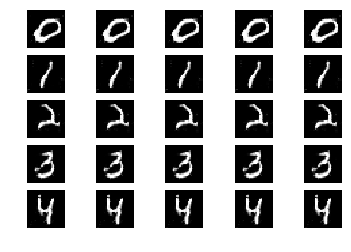

In [50]:
# training the network

# generating new images from trained network
import matplotlib.pyplot as plt

r, c = 5, 5
noise = np.random.normal(0, 1, (10, 100))

gen_imgs = []

for indx in range(5):
    gen_imgs.extend(generator_model.predict([np.array([indx]*5), noise]))
    
# Rescale images 0 - 1
gen_imgs = np.array(gen_imgs)
gen_imgs = 0.5 * gen_imgs + 0.5
fig, axs = plt.subplots(r, c)
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
        axs[i,j].axis('off')
        cnt += 1
        
plt.show()
fig.savefig("mnist.png")
plt.close()